In [1]:
!nvidia-smi

Wed Mar 22 12:43:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 461.79       Driver Version: 461.79       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 306... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   42C    P8     8W /  N/A |   2569MiB /  6144MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 1. Build your own convolutional neural network using pytorch

In [1]:
import os
import pandas as pd
from torchvision.io import read_image


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from torch.utils.data import Dataset,DataLoader, random_split, ConcatDataset
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.cuda.amp import autocast, GradScaler

from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.tensorboard import SummaryWriter
from torch.optim import lr_scheduler

from PIL import Image
import matplotlib.pyplot as plt

In [2]:
torch.__version__

'1.9.0+cu111'

In [3]:
class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(conv_block, self).__init__()
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
    def forward(self, x):
        return self.relu(self.batchnorm(self.conv(x)))


    
    
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.stride = stride
        
        # Shortcut connection
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(residual)
        out = self.relu(out)
        return out
     
class Inception_block(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool):
        super(Inception_block, self).__init__()
        
        self.branch1= conv_block(in_channels, out_1x1, kernel_size = 1)
        
        self.branch2= nn.Sequential(
            conv_block(in_channels, red_3x3, kernel_size = 1),
            conv_block(red_3x3, out_3x3, kernel_size = 3, padding = 1)
            )
        
        self.branch3= nn.Sequential(
            conv_block(in_channels, red_5x5, kernel_size = 1),
            conv_block(red_5x5, out_5x5, kernel_size = 5, padding = 2)
            )
        
        self.branch4= nn.Sequential(
            nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 1),
            conv_block(in_channels, out_1x1pool, kernel_size = 1)
            )
    
    def forward(self, x):
      #print(self.branch1(x).shape)
      #print(self.branch2(x).shape)
      #print(self.branch3(x).shape)
      #print(self.branch4(x).shape)
        return torch.cat([self.branch1(x),self.branch2(x),self.branch3(x),self.branch4(x)],1)

class CNNModel(nn.Module):
    def __init__(self, num_classes=4):
        super(CNNModel, self).__init__()
     
        # in_channels, out_channels, kernel_size, padding, num_blocks
        self.layer1 = self._make_layer(3, 32, kernel_size=11, padding=5, num_blocks=4)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 1)        
        
        self.layer2 = self._make_layer(32, 64, kernel_size=7, padding=3, num_blocks=3)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 1)
        
        self.layer3 = self._make_layer(64, 128, kernel_size=5, padding=2, num_blocks=3)
        self.maxpool3 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 1)
             
        self.layer4 = self._make_layer(128, 256, kernel_size=3, padding=1, num_blocks=2)
        self.maxpool4 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 1)
        
        self.layer5 = self._make_layer(256, 512, kernel_size=3, padding=1, num_blocks=2)
        self.maxpool5 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 1)
        
        self.layer6 = self._make_layer(512, 512, kernel_size=3, padding=1, num_blocks=2)
        self.maxpool6 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 1)
        
        self.fc1 = nn.Linear(512*5*5, 64)
        self.fc2 = nn.Linear(64, 4)
        #self.fc3 = nn.Linear(128, 64)
        #self.fc4 = nn.Linear(64, 4)
 
    def _make_layer(self, in_channels, out_channels, kernel_size, padding, num_blocks=1):
        layers = []
        layers.append(conv_block(in_channels, out_channels,kernel_size=kernel_size, padding=padding))
        for _ in range(1, num_blocks):
            layers.append(conv_block(out_channels, out_channels,kernel_size=kernel_size, padding=padding))
        return nn.Sequential(*layers)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.maxpool1(out)
        out = self.layer2(out)
        out = self.maxpool2(out)      
        out = self.layer3(out)
        out = self.maxpool3(out)
        out = self.layer4(out)
        out = self.maxpool4(out)
        out = self.layer5(out)
        out = self.maxpool5(out)
        out = self.layer6(out)
        out = self.maxpool6(out)        
        #print(out.shape)
        out = torch.flatten(out, 1)
        out = self.fc1(out)
        out = self.fc2(out)
        #out = self.fc3(out)
        #out = self.fc4(out)
        return out
    
class Incetionresidual(nn.Module):
    def __init__(self, num_classes=4):
        super(Incetionresidual, self).__init__()
        self.conv1 = conv_block(in_channels = 3, out_channels= 64, kernel_size = 7, stride = 2, padding = 3)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.conv2 = conv_block(64,192, kernel_size = 3, stride = 1, padding = 1)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

        #  in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool
        self.in3a = Inception_block(192,64,96,128,16,32,32)
        self.in3b = Inception_block(256,128,128,192,32,96,64)
        self.maxpool3 = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.in4a = Inception_block(480,192,96,208,16,48,64)
        self.in4b = Inception_block(512,160,112,224,24,64,64)
        self.in4c = Inception_block(512,128,128,256,24,64,64)
        self.in4d = Inception_block(512,112,144,288,32,64,64)
        self.in4e = Inception_block(528,256,160,320,32,128,128)
        self.maxpool4 = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
      
        self.layer1 = self._make_layer(528, 64, 3)
        self.layer2 = self._make_layer(64, 128, 3, stride=2)
        self.layer3 = self._make_layer(128, 256, 3, stride=2)
        self.layer4 = self._make_layer(256, 512, 3, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 4)
        
    def _make_layer(self, in_channels, out_channels, num_blocks, stride=1):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.maxpool1(out)
        out = self.conv2(out)
        out = self.maxpool2(out) 
        out = self.in3a(out)
        out = self.in3b(out)
        out = self.maxpool3(out)
        out = self.in4a(out)
        out = self.in4b(out)
        out = self.in4c(out)
        out = self.in4d(out)
        out = self.maxpool4(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        #print(out.shape)
        out = torch.flatten(out, 1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        return out

# 2. Train your model using cow teat datasets (you may need to use  Google Colab (or Kaggle) with GPU to train your code) 

### (1) use torchvision.datasets.ImageFolder for the training dataset
### (2) use custom dataloader for test dataset (return image tensor and file name)

In [4]:

class TestSet(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.img_labels = os.listdir(img_dir)
        self.transform = transform
        

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels[idx])
        image = Image.open(img_path) 
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)

        return image, label


In [5]:
train_dir = r'D:\application for the usa\YU\6. Deep learning\HW 6 NN for cow teats classification\Train'
test_dir = r'D:\application for the usa\YU\6. Deep learning\HW 6 NN for cow teats classification\Test'


In [8]:
batch_size = 5
ori_transform = transforms.Compose([transforms.Resize((275,275)),
                                    transforms.RandomCrop((224, 224)),
                                    transforms.ToTensor()])
train_dir = r'D:\application for the usa\YU\6. Deep learning\HW 6 NN for cow teats classification\Train'
train_data = ImageFolder(train_dir,transform = ori_transform)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

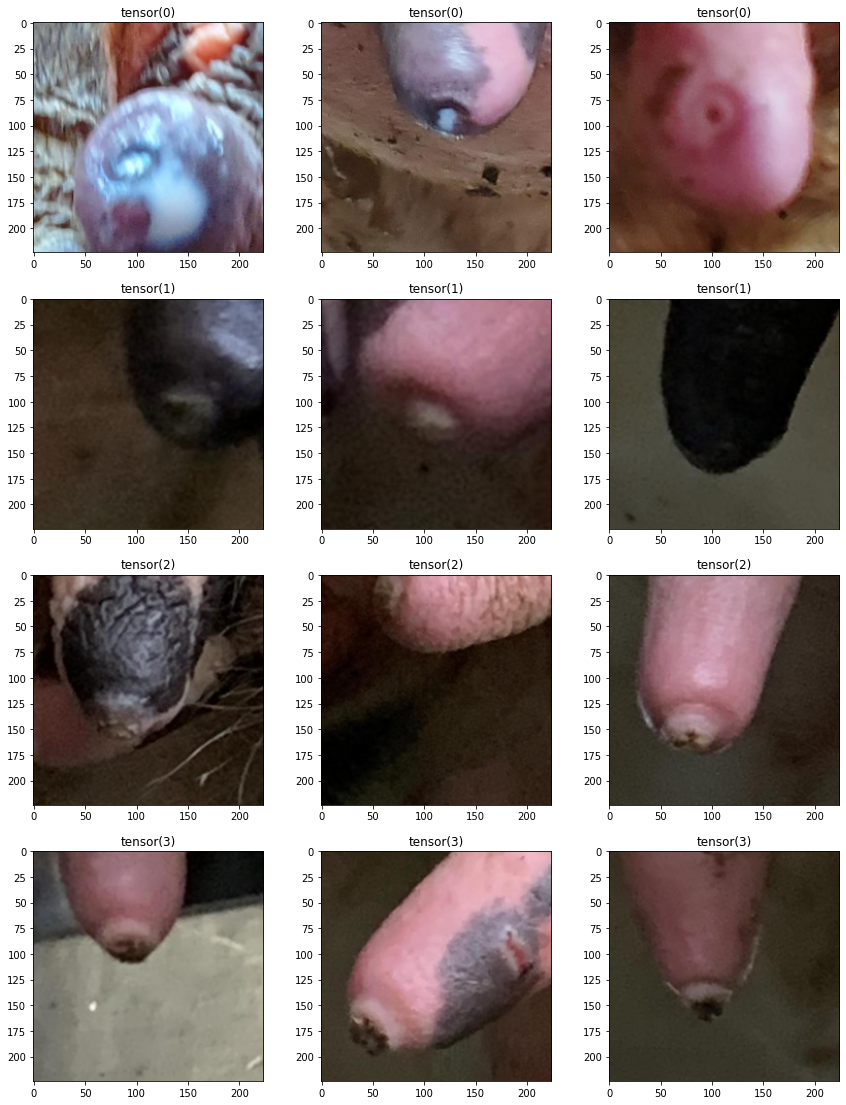

In [9]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
class_0=[]
class_1=[]
class_2=[]
class_3=[]
plt.figure(figsize=(15,15))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.2, wspace=0.1)
loc_1 = 1
loc_2 = 4
loc_3 = 7
loc_4 = 10

while len(class_0)<3 or len(class_1)<3 or len(class_2)<3 or len(class_3)<3:
    images, labels = next(iter(train_loader))
    for i in range(len(labels)):
        if labels[i]==0 and len(class_0)<3:
            #print(labels[i])
            plt.subplot(4,3,loc_1)
            plt.imshow(images[i].permute(1,2,0), 'gray')
            plt.title(str(labels[i]))
            class_0.append(labels[i])
            loc_1+=1
           
        if labels[i]==1 and len(class_1)<3:
            
            #print(labels[i])
            plt.subplot(4,3,loc_2)
            plt.imshow(images[i].permute(1,2,0), 'gray')
            plt.title(str(labels[i]))
            class_1.append(labels[i])
            loc_2+=1
        if labels[i]==2 and len(class_2)<3:
            
            #print(labels[i])
            plt.subplot(4,3,loc_3)
            plt.imshow(images[i].permute(1,2,0), 'gray')
            plt.title(str(labels[i]))
            class_2.append(labels[i])
            loc_3+=1
        if labels[i]==3 and len(class_3)<3:
            
            #print(labels[i])
            plt.subplot(4,3,loc_4)
            plt.imshow(images[i].permute(1,2,0), 'gray')
            plt.title(str(labels[i]))
            class_3.append(labels[i]) 
            loc_4+=1

In [19]:
model = CNNModel().to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6, weight_decay=1e-5)

In [4]:
batch_size = 8
transform = transforms.Compose([transforms.Resize((275, 275)),
                                    transforms.RandomRotation((-20,20)),
                                    transforms.RandomCrop((224, 224)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [5]:
test_transform = transforms.Compose([transforms.Resize((275,275)),
                                    transforms.RandomCrop((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [6]:

train_data = ImageFolder(train_dir,transform = transform)


 # Random split
train_set_size = int(len(train_data) * 0.8)
valid_set_size = len(train_data) - train_set_size
train_set, valid_set = random_split(train_data, [train_set_size, valid_set_size])

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_set, batch_size=batch_size, shuffle=True)



In [7]:

test_dataset = TestSet(img_dir = test_dir, transform = test_transform)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False, num_workers = 0)

In [25]:
from datetime import datetime
start_time = datetime.now()

all_trainloss= []
all_valloss= []
all_acc = []
all_train_acc=[]
steps = 300

for epoch in range(steps):
    train_loss = 0
    train_correct=0
    for batch in train_loader:
        x, y = batch

        x, y = x.to('cuda'), y.to('cuda')
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)      
        loss.backward()
        optimizer.step() 
        train_loss+=loss.item()   
        predict = pred.argmax(dim=1, keepdim=True)
        train_correct += predict.eq(y.view_as(predict)).sum().item()
        
    train_acc = 100. * train_correct / len(train_loader.dataset)        
    model.eval()
    val_loss = 0
    correct = 0
    for data, target in valid_loader:
        data, target = data.to('cuda'), target.to('cuda')
        output = model(data)
        val_loss += criterion(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
    train_loss/=len(train_loader)
    val_loss /= len(valid_loader)
    accuracy = 100. * correct / len(valid_loader.dataset)
    
    #scheduler.step(val_loss)
    
    if accuracy >= 66 or (epoch+1)%100 == 0:
        PATH = f'NN7_0316_{epoch+1}.pth'
        torch.save(model.state_dict(), PATH)        
    
    all_trainloss.append(train_loss)
    all_train_acc.append(train_acc)    
    all_valloss.append(val_loss)
    all_acc.append(accuracy)
    
    if (epoch+1)%10 ==0:
        print(f'Epoch:{epoch+1} | Train Loss: {train_loss}| train_acc:{train_acc} | Validation Loss:{val_loss} | val_acc:{accuracy}')
        print()
        
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Epoch:10 | Train Loss: 0.8699185337709344| train_acc:62.24156692056583 | Validation Loss:0.917693594406391 | val_acc:56.52173913043478

Epoch:20 | Train Loss: 0.8014602964339049| train_acc:65.28835690968444 | Validation Loss:0.9187770670857923 | val_acc:59.130434782608695

Epoch:30 | Train Loss: 0.773199537007705| train_acc:67.46463547334059 | Validation Loss:0.9050450402087179 | val_acc:59.130434782608695

Epoch:40 | Train Loss: 0.7113327928211378| train_acc:71.27312295973884 | Validation Loss:0.9730179988104721 | val_acc:57.391304347826086

Epoch:50 | Train Loss: 0.6877234881338866| train_acc:70.5114254624592 | Validation Loss:0.9367406820428783 | val_acc:60.43478260869565

Epoch:60 | Train Loss: 0.6306240348712258| train_acc:73.99347116430903 | Validation Loss:0.9231803961868944 | val_acc:60.0

Epoch:70 | Train Loss: 0.590295939600986| train_acc:75.62568008705114 | Validation Loss:0.9532276114513134 | val_acc:56.52173913043478

Epoch:80 | Train Loss: 0.5226390784201415| train_acc:79

In [26]:
print('Duration: {}'.format(end_time - start_time))

Duration: 6:13:38.383435


In [27]:
df = pd.DataFrame(zip(all_trainloss,all_train_acc,all_valloss,all_acc))

In [34]:
df.to_csv('NN_7_0316_2.csv')

In [36]:
index = [100,200,300]

In [37]:
for i in index:

    PATH = f'NN7_0316_{i}.pth'
    model.load_state_dict(torch.load(PATH))
    model.eval()
    
    CNN_pred=[]
    test_y=[]
    with torch.no_grad():
        for data in test_loader:
            x, y = data
            #print(y)
            x = x.to('cuda')
            outputs = model(x)
            _, predicted = torch.max(outputs.data, 1)
            CNN_pred+=predicted.tolist()
            test_y+= list(y)
    res =  pd.DataFrame(list(zip(test_y, CNN_pred)))
    res.to_csv(f'NN7_0316_{i}_prediction.csv',index=False,header=False)

In [3]:
model = Incetionresidual().to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6, weight_decay=1e-5)

In [8]:
from datetime import datetime
start_time = datetime.now()

all_trainloss= []
all_valloss= []
all_acc = []
all_train_acc=[]
steps = 300

for epoch in range(steps):
    train_loss = 0
    train_correct=0
    for batch in train_loader:
        x, y = batch

        x, y = x.to('cuda'), y.to('cuda')
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)      
        loss.backward()
        optimizer.step() 
        train_loss+=loss.item()   
        predict = pred.argmax(dim=1, keepdim=True)
        train_correct += predict.eq(y.view_as(predict)).sum().item()
        
    train_acc = 100. * train_correct / len(train_loader.dataset)        
        
    model.eval()
    val_loss = 0
    correct = 0
    for data, target in valid_loader:
        data, target = data.to('cuda'), target.to('cuda')
        output = model(data)
        val_loss += criterion(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
    train_loss/=len(train_loader)
    val_loss /= len(valid_loader)
    accuracy = 100. * correct / len(valid_loader.dataset)
    
    #scheduler.step(val_loss)
    
    if accuracy >= 66 or (epoch+1)%100 == 0:
        PATH = f'IN7_0316_{epoch+1}.pth'
        torch.save(model.state_dict(), PATH)        
    
    all_trainloss.append(train_loss)
    all_train_acc.append(train_acc)    
    all_valloss.append(val_loss)
    all_acc.append(accuracy)
    
    if (epoch+1)%10 !=0:
        print(f'Epoch:{epoch+1} | Train Loss: {train_loss}| train_acc:{train_acc} | Validation Loss:{val_loss} | val_acc:{accuracy}')
        print()
        
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

C:\Users\User\anaconda3\envs\dlenv\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch:1 | Train Loss: 1.406138193089029| train_acc:16.32208922742111 | Validation Loss:1.3708502424174343 | val_acc:33.47826086956522

Epoch:2 | Train Loss: 1.268011492231618| train_acc:47.1164309031556 | Validation Loss:1.1959171500699273 | val_acc:53.04347826086956

Epoch:3 | Train Loss: 1.155604638742364| train_acc:54.515778019586506 | Validation Loss:1.0967836318344906 | val_acc:57.391304347826086

Epoch:4 | Train Loss: 1.0756723206976186| train_acc:54.95103373231774 | Validation Loss:1.0846050957153583 | val_acc:50.0

Epoch:5 | Train Loss: 1.0440951824188232| train_acc:53.75408052230686 | Validation Loss:1.0559296998484382 | val_acc:52.17391304347826

Epoch:6 | Train Loss: 1.0093983966371287| train_acc:55.16866158868335 | Validation Loss:1.0549918947548702 | val_acc:51.73913043478261

Epoch:7 | Train Loss: 0.9920482169026914| train_acc:55.49510337323177 | Validation Loss:1.0475808032627763 | val_acc:55.65217391304348

Epoch:8 | Train Loss: 0.9674655090207639| train_acc:59.52121871

Epoch:68 | Train Loss: 0.7610749869242959| train_acc:64.8531011969532 | Validation Loss:0.9510321391039881 | val_acc:57.82608695652174

Epoch:69 | Train Loss: 0.7513714235761891| train_acc:65.94124047878128 | Validation Loss:0.9775975120478663 | val_acc:59.56521739130435

Epoch:71 | Train Loss: 0.7618941918663357| train_acc:65.28835690968444 | Validation Loss:0.9799017947295616 | val_acc:59.56521739130435

Epoch:72 | Train Loss: 0.7630679459675499| train_acc:67.13819368879217 | Validation Loss:0.978272944688797 | val_acc:56.52173913043478

Epoch:73 | Train Loss: 0.7621095641799595| train_acc:65.28835690968444 | Validation Loss:0.935750059012709 | val_acc:59.130434782608695

Epoch:74 | Train Loss: 0.7812827320202537| train_acc:65.39717083786725 | Validation Loss:0.9400381877504546 | val_acc:55.21739130434783

Epoch:75 | Train Loss: 0.743419375108636| train_acc:66.37649619151252 | Validation Loss:0.9610370315354446 | val_acc:61.30434782608695

Epoch:76 | Train Loss: 0.7533054198907769| t

Epoch:135 | Train Loss: 0.6394349756448166| train_acc:73.6670293797606 | Validation Loss:0.9749267902867548 | val_acc:61.73913043478261

Epoch:136 | Train Loss: 0.6039335070744805| train_acc:74.42872687704026 | Validation Loss:0.9984219526422435 | val_acc:61.73913043478261

Epoch:137 | Train Loss: 0.6401187273471252| train_acc:70.72905331882481 | Validation Loss:0.9926811271700365 | val_acc:60.43478260869565

Epoch:138 | Train Loss: 0.6184640888286673| train_acc:71.81719260065289 | Validation Loss:0.9446076267752154 | val_acc:59.130434782608695

Epoch:139 | Train Loss: 0.6395162023927854| train_acc:70.72905331882481 | Validation Loss:1.049196237120135 | val_acc:63.47826086956522

Epoch:141 | Train Loss: 0.6333099788945654| train_acc:73.23177366702939 | Validation Loss:1.0079358394803672 | val_acc:61.73913043478261

Epoch:142 | Train Loss: 0.6097175103166829| train_acc:74.9727965179543 | Validation Loss:1.0037383334390049 | val_acc:62.17391304347826

Epoch:143 | Train Loss: 0.6100510877

Epoch:202 | Train Loss: 0.5030180977738422| train_acc:78.78128400435256 | Validation Loss:1.1440998747431 | val_acc:59.56521739130435

Epoch:203 | Train Loss: 0.4918106058369512| train_acc:79.10772578890098 | Validation Loss:1.1423461509161983 | val_acc:57.391304347826086

Epoch:204 | Train Loss: 0.497004457919494| train_acc:81.71926006528835 | Validation Loss:1.1399822964750488 | val_acc:59.56521739130435

Epoch:205 | Train Loss: 0.4708589266175809| train_acc:80.73993471164309 | Validation Loss:1.0876226188807652 | val_acc:59.56521739130435

Epoch:206 | Train Loss: 0.4986091502982637| train_acc:79.97823721436343 | Validation Loss:1.1961588582088207 | val_acc:63.47826086956522

Epoch:207 | Train Loss: 0.5005347816192586| train_acc:77.80195865070729 | Validation Loss:1.0255810978083775 | val_acc:61.30434782608695

Epoch:208 | Train Loss: 0.4948074555267458| train_acc:80.8487486398259 | Validation Loss:1.2129234671592712 | val_acc:60.43478260869565

Epoch:209 | Train Loss: 0.508155262470

Epoch:268 | Train Loss: 0.4173871050386325| train_acc:83.24265505984766 | Validation Loss:1.330058792541767 | val_acc:58.26086956521739

Epoch:269 | Train Loss: 0.3930935145720192| train_acc:84.11316648531012 | Validation Loss:1.2714895965724156 | val_acc:60.43478260869565

Epoch:271 | Train Loss: 0.37697848480032836| train_acc:84.43960826985854 | Validation Loss:1.2590418848498115 | val_acc:56.95652173913044

Epoch:272 | Train Loss: 0.39093495218650154| train_acc:84.22198041349293 | Validation Loss:1.260388850138105 | val_acc:61.30434782608695

Epoch:273 | Train Loss: 0.3917204634650894| train_acc:83.67791077257888 | Validation Loss:1.2062485433858017 | val_acc:62.17391304347826

Epoch:274 | Train Loss: 0.3744395180888798| train_acc:85.52774755168662 | Validation Loss:1.3211170897401612 | val_acc:56.52173913043478

Epoch:275 | Train Loss: 0.3740355569059434| train_acc:84.65723612622416 | Validation Loss:1.2879515218323674 | val_acc:58.69565217391305

Epoch:276 | Train Loss: 0.39291884

In [9]:
print('Duration: {}'.format(end_time - start_time))

Duration: 1:31:38.289998


In [12]:
df = pd.DataFrame(zip(all_trainloss,all_train_acc,all_valloss,all_acc))

In [13]:
index = (df[df.iloc[:,3]>=66].index.values)+1

In [15]:
index

array([152, 181, 213, 244], dtype=int64)

In [16]:
df.to_csv('Inceptionresidual.csv')

In [9]:
for i in [152, 181, 213, 244, 100, 200, 300]:

    PATH = f'IN7_0316_{i}.pth'
    model.load_state_dict(torch.load(PATH))
    model.eval()
    
    CNN_pred=[]
    test_y=[]
    with torch.no_grad():
        for data in test_loader:
            x, y = data
            #print(y)
            x = x.to('cuda')
            outputs = model(x)
            _, predicted = torch.max(outputs.data, 1)
            CNN_pred+=predicted.tolist()
            test_y+= list(y)
    res =  pd.DataFrame(list(zip(test_y, CNN_pred)))
    res.to_csv(f'IN7_0316_{i}_prediction_2.csv',index=False,header=False)

C:\Users\User\anaconda3\envs\dlenv\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Text(0.5, 0, 'epoch')

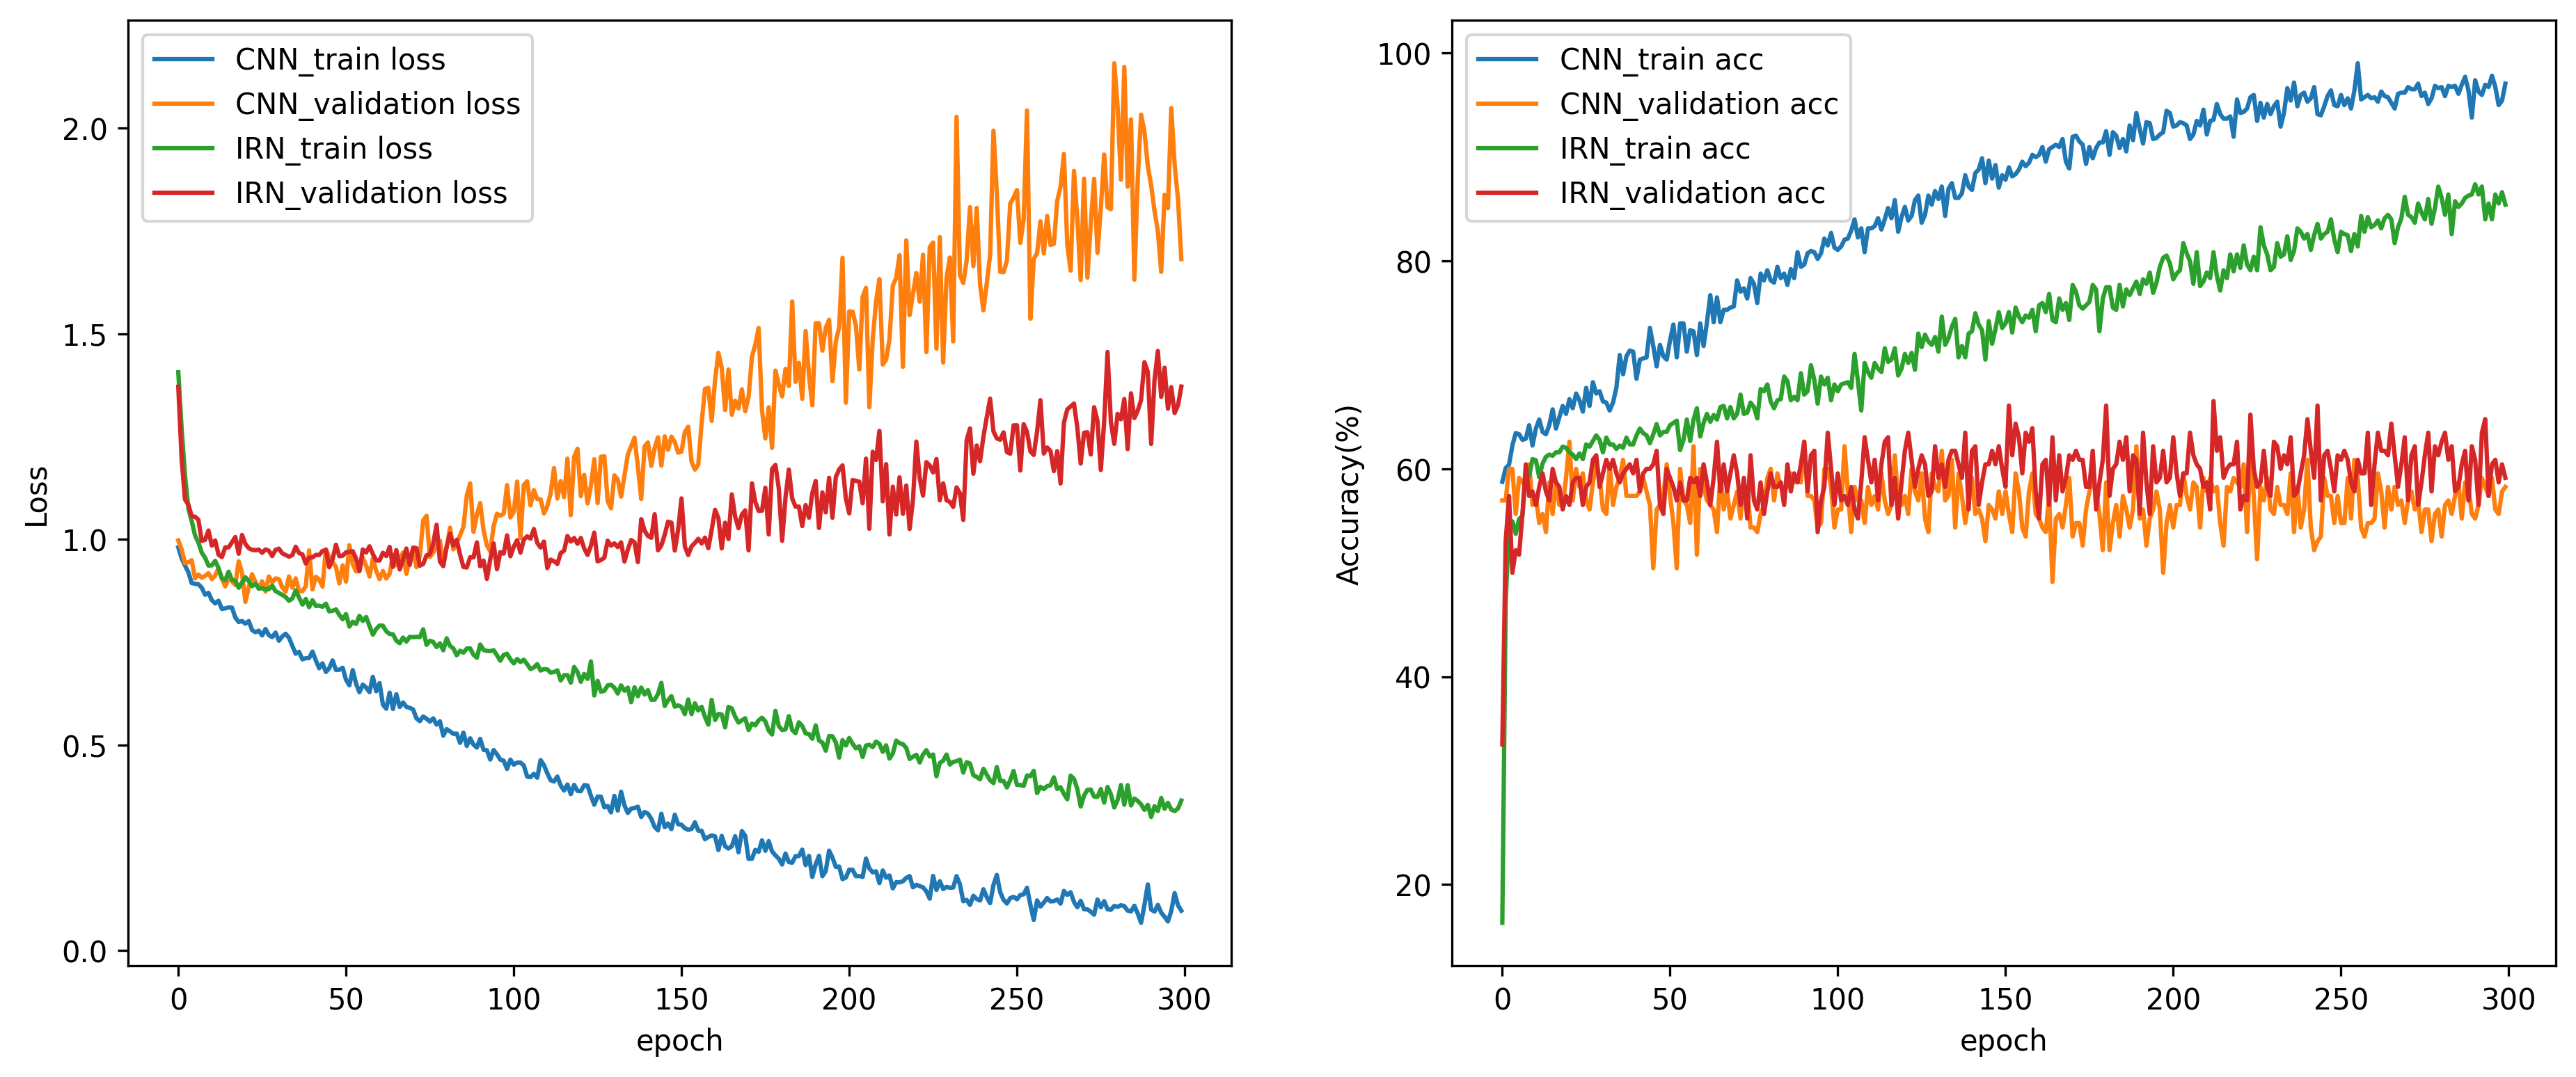

In [3]:
plt.rcParams['figure.dpi'] = 300
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
CNN=pd.read_csv('NN_7_0316_2.csv')
IRN=pd.read_csv('IN_7_0316.csv')
x = [i for i in range(300)]
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(x, CNN.iloc[:,1])
plt.plot(x, CNN.iloc[:,-2])
plt.plot(x, IRN.iloc[:,1])
plt.plot(x, IRN.iloc[:,-2])
plt.legend(['CNN_train loss','CNN_validation loss','IRN_train loss','IRN_validation loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')


plt.subplot(122)
plt.plot(x, CNN.iloc[:,2])
plt.plot(x, CNN.iloc[:,-1])
plt.plot(x, IRN.iloc[:,2])
plt.plot(x, IRN.iloc[:,-1])
plt.legend(['CNN_train acc','CNN_validation acc','IRN_train acc','IRN_validation acc'])
plt.ylabel('Accuracy(%)')
plt.xlabel('epoch')

In [3]:
batch_size = 16
transform = transforms.Compose([transforms.Resize((275, 275)),
                                    transforms.RandomRotation((-20,20)),
                                    transforms.RandomCrop((224, 224)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [4]:
test_transform = transforms.Compose([transforms.Resize((275,275)),
                                    transforms.RandomCrop((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


In [5]:
train_dir = r'D:\application for the usa\YU\6. Deep learning\HW 6 NN for cow teats classification\Train'
train_data = ImageFolder(train_dir,transform = transform)
 # Random split
train_set_size = int(len(train_data) * 0.8)
valid_set_size = len(train_data) - train_set_size
train_set, valid_set = random_split(train_data, [train_set_size, valid_set_size])

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_set, batch_size=batch_size, shuffle=True)

In [6]:
model = Incetionresidual().to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6, weight_decay=1e-5)

In [8]:
from datetime import datetime
start_time = datetime.now()

all_trainloss= []
all_valloss= []
all_acc = []
all_train_acc=[]
steps = 300

for epoch in range(steps):
    train_loss = 0
    train_correct=0
    for batch in train_loader:
        x, y = batch

        x, y = x.to('cuda'), y.to('cuda')
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)      
        loss.backward()
        optimizer.step() 
        train_loss+=loss.item()   
        predict = pred.argmax(dim=1, keepdim=True)
        train_correct += predict.eq(y.view_as(predict)).sum().item()
        
    train_acc = 100. * train_correct / len(train_loader.dataset)        
        
    
    

    model.eval()
    val_loss = 0
    correct = 0
    for data, target in valid_loader:
        data, target = data.to('cuda'), target.to('cuda')
        output = model(data)
        val_loss += criterion(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
    train_loss/=len(train_loader)
    val_loss /= len(valid_loader)
    accuracy = 100. * correct / len(valid_loader.dataset)
    
    #scheduler.step(val_loss)
    
    if accuracy >= 66 or (epoch+1)%100 == 0:
        PATH = f'NN7_0316_{epoch+1}_16.pth'
        torch.save(model.state_dict(), PATH)        
    
    all_trainloss.append(train_loss)
    all_train_acc.append(train_acc)    
    all_valloss.append(val_loss)
    all_acc.append(accuracy)
    
    if (epoch+1)%10 !=0:
        print(f'Epoch:{epoch+1} | Train Loss: {train_loss}| train_acc:{train_acc} | Validation Loss:{val_loss} | val_acc:{accuracy}')
        print()
        
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

C:\Users\User\anaconda3\envs\dlenv\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch:1 | Train Loss: 1.3999449261303605| train_acc:23.39499455930359 | Validation Loss:1.3877801815668742 | val_acc:25.217391304347824

Epoch:2 | Train Loss: 1.3274252990196491| train_acc:44.28726877040261 | Validation Loss:1.2710678497950236 | val_acc:44.78260869565217

Epoch:3 | Train Loss: 1.2405353620134552| train_acc:48.63982589771491 | Validation Loss:1.1902785539627074 | val_acc:48.26086956521739

Epoch:4 | Train Loss: 1.160403950461026| train_acc:53.101196953210014 | Validation Loss:1.0941486318906148 | val_acc:53.91304347826087

Epoch:5 | Train Loss: 1.091504376510094| train_acc:52.9923830250272 | Validation Loss:1.047625474135081 | val_acc:51.73913043478261

Epoch:6 | Train Loss: 1.0629589465157738| train_acc:53.75408052230686 | Validation Loss:1.0287360231081644 | val_acc:53.91304347826087

Epoch:7 | Train Loss: 1.0472060904420655| train_acc:56.25680087051143 | Validation Loss:0.9895434180895487 | val_acc:57.391304347826086

Epoch:8 | Train Loss: 1.0237281476629192| train_a

Epoch:68 | Train Loss: 0.8152802339915571| train_acc:64.41784548422198 | Validation Loss:0.8767073273658752 | val_acc:62.17391304347826

Epoch:69 | Train Loss: 0.8230036779724318| train_acc:64.6354733405876 | Validation Loss:0.8362374782562256 | val_acc:60.869565217391305

Epoch:71 | Train Loss: 0.8295063828599865| train_acc:63.98258977149075 | Validation Loss:0.8774841626485189 | val_acc:63.91304347826087

Epoch:72 | Train Loss: 0.8397024674662228| train_acc:64.20021762785636 | Validation Loss:0.846184625228246 | val_acc:61.30434782608695

Epoch:73 | Train Loss: 0.8090736249397541| train_acc:65.07072905331883 | Validation Loss:0.8502498030662536 | val_acc:60.43478260869565

Epoch:74 | Train Loss: 0.8252178055459055| train_acc:63.32970620239391 | Validation Loss:0.8697628657023112 | val_acc:59.130434782608695

Epoch:75 | Train Loss: 0.8188268532013071| train_acc:65.28835690968444 | Validation Loss:0.9065047065416972 | val_acc:57.82608695652174

Epoch:76 | Train Loss: 0.8199004047903521

Epoch:135 | Train Loss: 0.6995103256455784| train_acc:69.64091403699673 | Validation Loss:0.8770421822865804 | val_acc:63.91304347826087

Epoch:136 | Train Loss: 0.693009522454492| train_acc:69.96735582154515 | Validation Loss:0.8669703642527262 | val_acc:61.73913043478261

Epoch:137 | Train Loss: 0.6859165142322409| train_acc:69.96735582154515 | Validation Loss:0.8844359834988912 | val_acc:60.869565217391305

Epoch:138 | Train Loss: 0.7063102326516447| train_acc:69.53210010881392 | Validation Loss:0.9080990612506866 | val_acc:59.130434782608695

Epoch:139 | Train Loss: 0.7020666655795328| train_acc:70.620239390642 | Validation Loss:0.8735663950443268 | val_acc:63.47826086956522

Epoch:141 | Train Loss: 0.7051761818343195| train_acc:70.07616974972797 | Validation Loss:0.8718361139297486 | val_acc:62.17391304347826

Epoch:142 | Train Loss: 0.6668401088180214| train_acc:70.29379760609358 | Validation Loss:0.8694113115469615 | val_acc:62.17391304347826

Epoch:143 | Train Loss: 0.698094857

Epoch:202 | Train Loss: 0.6034583151340485| train_acc:72.25244831338411 | Validation Loss:0.953334798415502 | val_acc:60.869565217391305

Epoch:203 | Train Loss: 0.606114472808509| train_acc:75.19042437431992 | Validation Loss:0.9136216878890991 | val_acc:59.56521739130435

Epoch:204 | Train Loss: 0.5803407101795591| train_acc:73.55821545157781 | Validation Loss:0.8660231987635295 | val_acc:61.30434782608695

Epoch:205 | Train Loss: 0.5816901187444555| train_acc:77.80195865070729 | Validation Loss:0.9098675787448883 | val_acc:58.26086956521739

Epoch:206 | Train Loss: 0.5868350483220199| train_acc:76.27856365614798 | Validation Loss:0.9229965011278788 | val_acc:62.17391304347826

Epoch:207 | Train Loss: 0.5983414516366762| train_acc:74.31991294885745 | Validation Loss:0.9089646975199381 | val_acc:58.69565217391305

Epoch:208 | Train Loss: 0.6033865768333961| train_acc:74.75516866158868 | Validation Loss:0.9873364587624868 | val_acc:61.73913043478261

Epoch:209 | Train Loss: 0.610810770

Epoch:268 | Train Loss: 0.5205478873746149| train_acc:78.23721436343853 | Validation Loss:1.0142673591772715 | val_acc:63.47826086956522

Epoch:269 | Train Loss: 0.4589519364566639| train_acc:81.39281828073993 | Validation Loss:0.9780294716358184 | val_acc:61.73913043478261

Epoch:271 | Train Loss: 0.46741590931497773| train_acc:80.52230685527748 | Validation Loss:0.9540009677410126 | val_acc:59.56521739130435

Epoch:272 | Train Loss: 0.486147192274702| train_acc:78.0195865070729 | Validation Loss:0.9753054718176524 | val_acc:62.608695652173914

Epoch:273 | Train Loss: 0.47833399140629274| train_acc:79.97823721436343 | Validation Loss:1.033418607711792 | val_acc:57.82608695652174

Epoch:274 | Train Loss: 0.44960534302838917| train_acc:80.73993471164309 | Validation Loss:1.0263110597928364 | val_acc:60.0

Epoch:275 | Train Loss: 0.4696548357605934| train_acc:80.41349292709467 | Validation Loss:1.0444343169530232 | val_acc:59.56521739130435

Epoch:276 | Train Loss: 0.47000636211757| trai

In [9]:
print('Duration: {}'.format(end_time - start_time))

Duration: 1:02:38.233841


In [12]:
df = pd.DataFrame(zip(all_trainloss,all_train_acc,all_valloss,all_acc))

In [13]:
index = (df[df.iloc[:,3]>=66].index.values)+1

In [15]:
index

array([ 98, 147, 161, 171, 182, 227, 242, 282], dtype=int64)

In [16]:
df.to_csv('NN_7_0316_16.csv')

In [17]:
test_dataset = TestSet(img_dir = test_dir, transform = test_transform)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False, num_workers = 0)

In [18]:
for i in index:

    PATH = f'NN7_0316_{i}_16.pth'
    model.load_state_dict(torch.load(PATH))
    model.eval()
    
    CNN_pred=[]
    test_y=[]
    with torch.no_grad():
        for data in test_loader:
            x, y = data
            #print(y)
            x = x.to('cuda')
            outputs = model(x)
            _, predicted = torch.max(outputs.data, 1)
            CNN_pred+=predicted.tolist()
            test_y+= list(y)
    res =  pd.DataFrame(list(zip(test_y, CNN_pred)))
    res.to_csv(f'NN7_0316_{i}_16_prediction.csv',index=False,header=False)

In [3]:
batch_size = 32
transform = transforms.Compose([transforms.Resize((275, 275)),
                                    transforms.RandomRotation((-20,20)),
                                    transforms.RandomCrop((224, 224)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [4]:
test_transform = transforms.Compose([transforms.Resize((275,275)),
                                    transforms.RandomCrop((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


In [5]:
train_dir = r'D:\application for the usa\YU\6. Deep learning\HW 6 NN for cow teats classification\Train'
train_data = ImageFolder(train_dir,transform = transform)


 # Random split
train_set_size = int(len(train_data) * 0.8)
valid_set_size = len(train_data) - train_set_size
train_set, valid_set = random_split(train_data, [train_set_size, valid_set_size])

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_set, batch_size=batch_size, shuffle=True)



In [4]:
model = Incetionresidual().to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6, weight_decay=1e-5)

In [8]:
from datetime import datetime
start_time = datetime.now()

all_trainloss= []
all_valloss= []
all_acc = []
all_train_acc=[]
steps = 300

for epoch in range(steps):
    train_loss = 0
    train_correct=0
    for batch in train_loader:
        x, y = batch

        x, y = x.to('cuda'), y.to('cuda')
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)      
        loss.backward()
        optimizer.step() 
        train_loss+=loss.item()   
        predict = pred.argmax(dim=1, keepdim=True)
        train_correct += predict.eq(y.view_as(predict)).sum().item()
        
    train_acc = 100. * train_correct / len(train_loader.dataset)        
        
    
    

    model.eval()
    val_loss = 0
    correct = 0
    for data, target in valid_loader:
        data, target = data.to('cuda'), target.to('cuda')
        output = model(data)
        val_loss += criterion(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
    train_loss/=len(train_loader)
    val_loss /= len(valid_loader)
    accuracy = 100. * correct / len(valid_loader.dataset)
    
    #scheduler.step(val_loss)
    
    if accuracy >= 66 or (epoch+1)%100 == 0:
        PATH = f'NN7_0316_{epoch+1}_32.pth'
        torch.save(model.state_dict(), PATH)        
    
    all_trainloss.append(train_loss)
    all_train_acc.append(train_acc)    
    all_valloss.append(val_loss)
    all_acc.append(accuracy)
    
    if (epoch+1)%10 !=0:
        print(f'Epoch:{epoch+1} | Train Loss: {train_loss}| train_acc:{train_acc} | Validation Loss:{val_loss} | val_acc:{accuracy}')
        print()
        
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

C:\Users\User\anaconda3\envs\dlenv\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch:1 | Train Loss: 1.3781623840332031| train_acc:23.06855277475517 | Validation Loss:1.4070835411548615 | val_acc:16.52173913043478

Epoch:2 | Train Loss: 1.3900563922421685| train_acc:16.2132752992383 | Validation Loss:1.3630852699279785 | val_acc:16.52173913043478

Epoch:3 | Train Loss: 1.3418822946219608| train_acc:23.721436343852012 | Validation Loss:1.3129571825265884 | val_acc:48.26086956521739

Epoch:4 | Train Loss: 1.2995358623307327| train_acc:43.41675734494015 | Validation Loss:1.2724110037088394 | val_acc:49.130434782608695

Epoch:5 | Train Loss: 1.2633054585292423| train_acc:41.566920565832426 | Validation Loss:1.2246741205453873 | val_acc:47.82608695652174

Epoch:6 | Train Loss: 1.22966586310288| train_acc:41.45810663764962 | Validation Loss:1.199464201927185 | val_acc:47.82608695652174

Epoch:7 | Train Loss: 1.2009030210560765| train_acc:41.45810663764962 | Validation Loss:1.1795883923768997 | val_acc:47.82608695652174

Epoch:8 | Train Loss: 1.1775523917428379| train_a

Epoch:67 | Train Loss: 0.8309099222051686| train_acc:63.43852013057671 | Validation Loss:0.7700368538498878 | val_acc:67.82608695652173

Epoch:68 | Train Loss: 0.8380386664949614| train_acc:64.30903155603917 | Validation Loss:0.832498624920845 | val_acc:64.34782608695652

Epoch:69 | Train Loss: 0.8273529122615683| train_acc:64.20021762785636 | Validation Loss:0.7595357187092304 | val_acc:65.65217391304348

Epoch:71 | Train Loss: 0.8312451983320301| train_acc:64.52665941240478 | Validation Loss:0.8140846267342567 | val_acc:63.47826086956522

Epoch:72 | Train Loss: 0.8301349693331225| train_acc:64.20021762785636 | Validation Loss:0.7936507016420364 | val_acc:63.47826086956522

Epoch:73 | Train Loss: 0.8100159517649946| train_acc:64.8531011969532 | Validation Loss:0.8043679147958755 | val_acc:66.52173913043478

Epoch:74 | Train Loss: 0.8190109154273724| train_acc:65.28835690968444 | Validation Loss:0.8056429252028465 | val_acc:65.65217391304348

Epoch:75 | Train Loss: 0.8323542948426872| 

Epoch:134 | Train Loss: 0.6424360552738453| train_acc:73.34058759521218 | Validation Loss:0.803131215274334 | val_acc:66.08695652173913

Epoch:135 | Train Loss: 0.6058149235001926| train_acc:76.16974972796518 | Validation Loss:0.8744448721408844 | val_acc:65.65217391304348

Epoch:136 | Train Loss: 0.6220631753576213| train_acc:73.77584330794342 | Validation Loss:0.9406450092792511 | val_acc:62.608695652173914

Epoch:137 | Train Loss: 0.6142835863705339| train_acc:74.64635473340587 | Validation Loss:0.8173067308962345 | val_acc:62.608695652173914

Epoch:138 | Train Loss: 0.6153887222553122| train_acc:74.9727965179543 | Validation Loss:0.784171499311924 | val_acc:62.608695652173914

Epoch:139 | Train Loss: 0.6117955261263354| train_acc:75.0816104461371 | Validation Loss:0.7988256439566612 | val_acc:62.608695652173914

Epoch:141 | Train Loss: 0.6133934218308021| train_acc:75.40805223068553 | Validation Loss:0.8051064535975456 | val_acc:65.65217391304348

Epoch:142 | Train Loss: 0.61725956

Epoch:201 | Train Loss: 0.5075804385645636| train_acc:79.76060935799782 | Validation Loss:0.875662662088871 | val_acc:65.21739130434783

Epoch:202 | Train Loss: 0.5195061276698935| train_acc:78.67247007616974 | Validation Loss:0.8659771978855133 | val_acc:64.34782608695652

Epoch:203 | Train Loss: 0.4837618274935361| train_acc:80.8487486398259 | Validation Loss:0.9035080820322037 | val_acc:62.608695652173914

Epoch:204 | Train Loss: 0.4823473625141999| train_acc:80.95756256800871 | Validation Loss:0.9128123223781586 | val_acc:68.26086956521739

Epoch:205 | Train Loss: 0.43835621404236763| train_acc:82.69858541893362 | Validation Loss:1.0423528403043747 | val_acc:60.869565217391305

Epoch:206 | Train Loss: 0.4575873551697567| train_acc:80.63112078346029 | Validation Loss:0.9016243740916252 | val_acc:64.34782608695652

Epoch:207 | Train Loss: 0.4379750407975295| train_acc:80.63112078346029 | Validation Loss:0.9194659292697906 | val_acc:64.78260869565217

Epoch:208 | Train Loss: 0.4483010

Epoch:267 | Train Loss: 0.374752224519335| train_acc:85.63656147986943 | Validation Loss:1.0055269561707973 | val_acc:64.34782608695652

Epoch:268 | Train Loss: 0.3571154896555276| train_acc:85.52774755168662 | Validation Loss:1.0309607610106468 | val_acc:62.608695652173914

Epoch:269 | Train Loss: 0.35642995865180577| train_acc:85.2013057671382 | Validation Loss:1.253943994641304 | val_acc:63.47826086956522

Epoch:271 | Train Loss: 0.3918527328762515| train_acc:84.76605005440696 | Validation Loss:1.0161226242780685 | val_acc:61.73913043478261

Epoch:272 | Train Loss: 0.3649416434867629| train_acc:85.96300326441785 | Validation Loss:0.9908970780670643 | val_acc:61.30434782608695

Epoch:273 | Train Loss: 0.37478889730469933| train_acc:84.76605005440696 | Validation Loss:1.0354802832007408 | val_acc:63.47826086956522

Epoch:274 | Train Loss: 0.3895321061898922| train_acc:84.54842219804135 | Validation Loss:1.0203557014465332 | val_acc:63.47826086956522

Epoch:275 | Train Loss: 0.32376665

In [9]:
print('Duration: {}'.format(end_time - start_time))

Duration: 0:49:43.794846


In [12]:
df = pd.DataFrame(zip(all_trainloss,all_train_acc,all_valloss,all_acc))

In [13]:
index = (df[df.iloc[:,3]>=66].index.values)+1

In [15]:
index

array([ 45,  51,  61,  62,  64,  65,  67,  73,  79,  80,  87,  90,  93,
        96,  99, 100, 106, 113, 116, 121, 124, 128, 129, 130, 133, 134,
       145, 150, 154, 167, 169, 181, 183, 194, 200, 204, 213, 218, 222,
       230, 233, 240, 242, 245, 249, 251, 253, 258, 294, 295], dtype=int64)

In [16]:
df.to_csv('NN_7_0316_32.csv')

In [17]:
test_dataset = TestSet(img_dir = test_dir, transform = test_transform)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False, num_workers = 0)

In [18]:
for i in index:

    PATH = f'NN7_0316_{i}_32.pth'
    model.load_state_dict(torch.load(PATH))
    model.eval()
    
    CNN_pred=[]
    test_y=[]
    with torch.no_grad():
        for data in test_loader:
            x, y = data
            #print(y)
            x = x.to('cuda')
            outputs = model(x)
            _, predicted = torch.max(outputs.data, 1)
            CNN_pred+=predicted.tolist()
            test_y+= list(y)
    res =  pd.DataFrame(list(zip(test_y, CNN_pred)))
    res.to_csv(f'NN7_0316_{i}_32_prediction.csv',index=False,header=False)

In [6]:
batch_size = 36
transform = transforms.Compose([transforms.Resize((275, 275)),
                                    transforms.RandomRotation((-20,20)),
                                    transforms.RandomCrop((224, 224)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [7]:
test_transform = transforms.Compose([transforms.Resize((275,275)),
                                    transforms.RandomCrop((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


In [8]:
train_dir = r'D:\application for the usa\YU\6. Deep learning\HW 6 NN for cow teats classification\Train'
train_data = ImageFolder(train_dir,transform = transform)


 # Random split
train_set_size = int(len(train_data) * 0.8)
valid_set_size = len(train_data) - train_set_size
train_set, valid_set = random_split(train_data, [train_set_size, valid_set_size])

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_set, batch_size=batch_size, shuffle=True)



In [9]:
model = Incetionresidual().to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6, weight_decay=1e-5)

In [8]:
from datetime import datetime
start_time = datetime.now()

all_trainloss= []
all_valloss= []
all_acc = []
all_train_acc=[]
steps = 300

for epoch in range(steps):
    train_loss = 0
    train_correct=0
    for batch in train_loader:
        x, y = batch

        x, y = x.to('cuda'), y.to('cuda')
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)      
        loss.backward()
        optimizer.step() 
        train_loss+=loss.item()   
        predict = pred.argmax(dim=1, keepdim=True)
        train_correct += predict.eq(y.view_as(predict)).sum().item()
        
    train_acc = 100. * train_correct / len(train_loader.dataset)        
        
    
    

    model.eval()
    val_loss = 0
    correct = 0
    for data, target in valid_loader:
        data, target = data.to('cuda'), target.to('cuda')
        output = model(data)
        val_loss += criterion(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
    train_loss/=len(train_loader)
    val_loss /= len(valid_loader)
    accuracy = 100. * correct / len(valid_loader.dataset)
    
    #scheduler.step(val_loss)
    
    if accuracy >= 66 or (epoch+1)%100 == 0:
        PATH = f'NN7_0316_{epoch+1}_36.pth'
        torch.save(model.state_dict(), PATH)        
    
    all_trainloss.append(train_loss)
    all_train_acc.append(train_acc)    
    all_valloss.append(val_loss)
    all_acc.append(accuracy)
    
    if (epoch+1)%10 !=0:
        print(f'Epoch:{epoch+1} | Train Loss: {train_loss}| train_acc:{train_acc} | Validation Loss:{val_loss} | val_acc:{accuracy}')
        print()
        
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

C:\Users\User\anaconda3\envs\dlenv\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch:1 | Train Loss: 1.4081531350429242| train_acc:23.5038084874864 | Validation Loss:1.3398302452904838 | val_acc:41.73913043478261

Epoch:2 | Train Loss: 1.33481365442276| train_acc:42.981501632208925 | Validation Loss:1.3211127179009574 | val_acc:41.73913043478261

Epoch:3 | Train Loss: 1.3118537939511812| train_acc:42.981501632208925 | Validation Loss:1.2984642812183924 | val_acc:41.73913043478261

Epoch:4 | Train Loss: 1.290126465834104| train_acc:42.981501632208925 | Validation Loss:1.2809595891407557 | val_acc:41.73913043478261

Epoch:5 | Train Loss: 1.269845384817857| train_acc:42.981501632208925 | Validation Loss:1.2595089844294958 | val_acc:41.73913043478261

Epoch:6 | Train Loss: 1.2490917490078852| train_acc:42.981501632208925 | Validation Loss:1.2444482701165336 | val_acc:41.73913043478261

Epoch:7 | Train Loss: 1.2327613738866954| train_acc:42.981501632208925 | Validation Loss:1.219333563532148 | val_acc:41.73913043478261

Epoch:8 | Train Loss: 1.2151803511839647| train_

Epoch:67 | Train Loss: 0.8755819568267236| train_acc:63.003264417845486 | Validation Loss:0.886807382106781 | val_acc:61.73913043478261

Epoch:68 | Train Loss: 0.8744438290596008| train_acc:63.98258977149075 | Validation Loss:0.8985780647822789 | val_acc:62.608695652173914

Epoch:69 | Train Loss: 0.8702379167079926| train_acc:63.43852013057671 | Validation Loss:0.8824299999645778 | val_acc:62.17391304347826

Epoch:71 | Train Loss: 0.869329225558501| train_acc:63.547334058759525 | Validation Loss:0.9176454799515861 | val_acc:62.17391304347826

Epoch:72 | Train Loss: 0.8737658101778764| train_acc:63.32970620239391 | Validation Loss:0.9020202926227024 | val_acc:62.17391304347826

Epoch:73 | Train Loss: 0.869733975483821| train_acc:63.547334058759525 | Validation Loss:0.8487339743546077 | val_acc:62.17391304347826

Epoch:74 | Train Loss: 0.8632334975095896| train_acc:63.43852013057671 | Validation Loss:0.8973606654575893 | val_acc:62.17391304347826

Epoch:75 | Train Loss: 0.86334627866745|

Epoch:135 | Train Loss: 0.7011317427341754| train_acc:71.38193688792165 | Validation Loss:0.862580554825919 | val_acc:65.21739130434783

Epoch:136 | Train Loss: 0.7082950266507956| train_acc:69.96735582154515 | Validation Loss:0.9351502997534615 | val_acc:60.869565217391305

Epoch:137 | Train Loss: 0.7143043233798101| train_acc:69.64091403699673 | Validation Loss:0.883944707257407 | val_acc:63.47826086956522

Epoch:138 | Train Loss: 0.6972022217053634| train_acc:71.16430903155604 | Validation Loss:0.8747156517846244 | val_acc:63.91304347826087

Epoch:139 | Train Loss: 0.6885380974182715| train_acc:72.14363438520131 | Validation Loss:0.9072467684745789 | val_acc:65.65217391304348

Epoch:141 | Train Loss: 0.6953344161693866| train_acc:70.83786724700762 | Validation Loss:0.9014117036546979 | val_acc:60.869565217391305

Epoch:142 | Train Loss: 0.690997485931103| train_acc:71.05549510337323 | Validation Loss:0.8929058824266706 | val_acc:62.17391304347826

Epoch:143 | Train Loss: 0.689527807

Epoch:202 | Train Loss: 0.5645668827570401| train_acc:77.9107725788901 | Validation Loss:0.934970464025225 | val_acc:62.608695652173914

Epoch:203 | Train Loss: 0.5765232191636012| train_acc:76.6050054406964 | Validation Loss:0.92988692011152 | val_acc:64.78260869565217

Epoch:204 | Train Loss: 0.578553509253722| train_acc:74.8639825897715 | Validation Loss:0.8959619615759168 | val_acc:63.47826086956522

Epoch:205 | Train Loss: 0.5488271885193311| train_acc:78.45484221980414 | Validation Loss:0.9379431009292603 | val_acc:63.04347826086956

Epoch:206 | Train Loss: 0.5594281244736451| train_acc:78.34602829162132 | Validation Loss:0.8705813373838153 | val_acc:62.17391304347826

Epoch:207 | Train Loss: 0.5460849507496908| train_acc:77.80195865070729 | Validation Loss:0.9888264536857605 | val_acc:62.608695652173914

Epoch:208 | Train Loss: 0.5648812238986676| train_acc:79.10772578890098 | Validation Loss:0.9206298249108451 | val_acc:64.78260869565217

Epoch:209 | Train Loss: 0.5437453847665

Epoch:268 | Train Loss: 0.4708880214737012| train_acc:81.39281828073993 | Validation Loss:0.9271055119378226 | val_acc:66.08695652173913

Epoch:269 | Train Loss: 0.45252680893127734| train_acc:82.80739934711643 | Validation Loss:1.0018852949142456 | val_acc:63.04347826086956

Epoch:271 | Train Loss: 0.453384593129158| train_acc:82.80739934711643 | Validation Loss:1.1295448201043266 | val_acc:58.26086956521739

Epoch:272 | Train Loss: 0.46225801224891955| train_acc:82.2633297062024 | Validation Loss:0.9857055289404733 | val_acc:62.17391304347826

Epoch:273 | Train Loss: 0.49780614559467024| train_acc:81.71926006528835 | Validation Loss:1.1137602840151106 | val_acc:60.0

Epoch:274 | Train Loss: 0.43997916751182997| train_acc:82.91621327529924 | Validation Loss:1.049650524343763 | val_acc:58.69565217391305

Epoch:275 | Train Loss: 0.4444971944277103| train_acc:82.69858541893362 | Validation Loss:0.9380183134760175 | val_acc:64.78260869565217

Epoch:276 | Train Loss: 0.45769728261690873| t

In [9]:
print('Duration: {}'.format(end_time - start_time))

Duration: 1:02:24.976470


In [12]:
df = pd.DataFrame(zip(all_trainloss,all_train_acc,all_valloss,all_acc))

In [13]:
index = (df[df.iloc[:,3]>=66].index.values)+1

In [15]:
index

array([118, 126, 143, 155, 185, 268, 282], dtype=int64)

In [16]:
df.to_csv('NN_7_0316_36.csv')

In [11]:
test_dataset = TestSet(img_dir = test_dir, transform = test_transform)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False, num_workers = 0)

In [18]:
for i in index:

    PATH = f'NN7_0316_{i}_36.pth'
    model.load_state_dict(torch.load(PATH))
    model.eval()
    
    CNN_pred=[]
    test_y=[]
    with torch.no_grad():
        for data in test_loader:
            x, y = data
            #print(y)
            x = x.to('cuda')
            outputs = model(x)
            _, predicted = torch.max(outputs.data, 1)
            CNN_pred+=predicted.tolist()
            test_y+= list(y)
    res =  pd.DataFrame(list(zip(test_y, CNN_pred)))
    res.to_csv(f'NN7_0316_{i}_36_prediction.csv',index=False,header=False)

Text(0.5, 0, 'epoch')

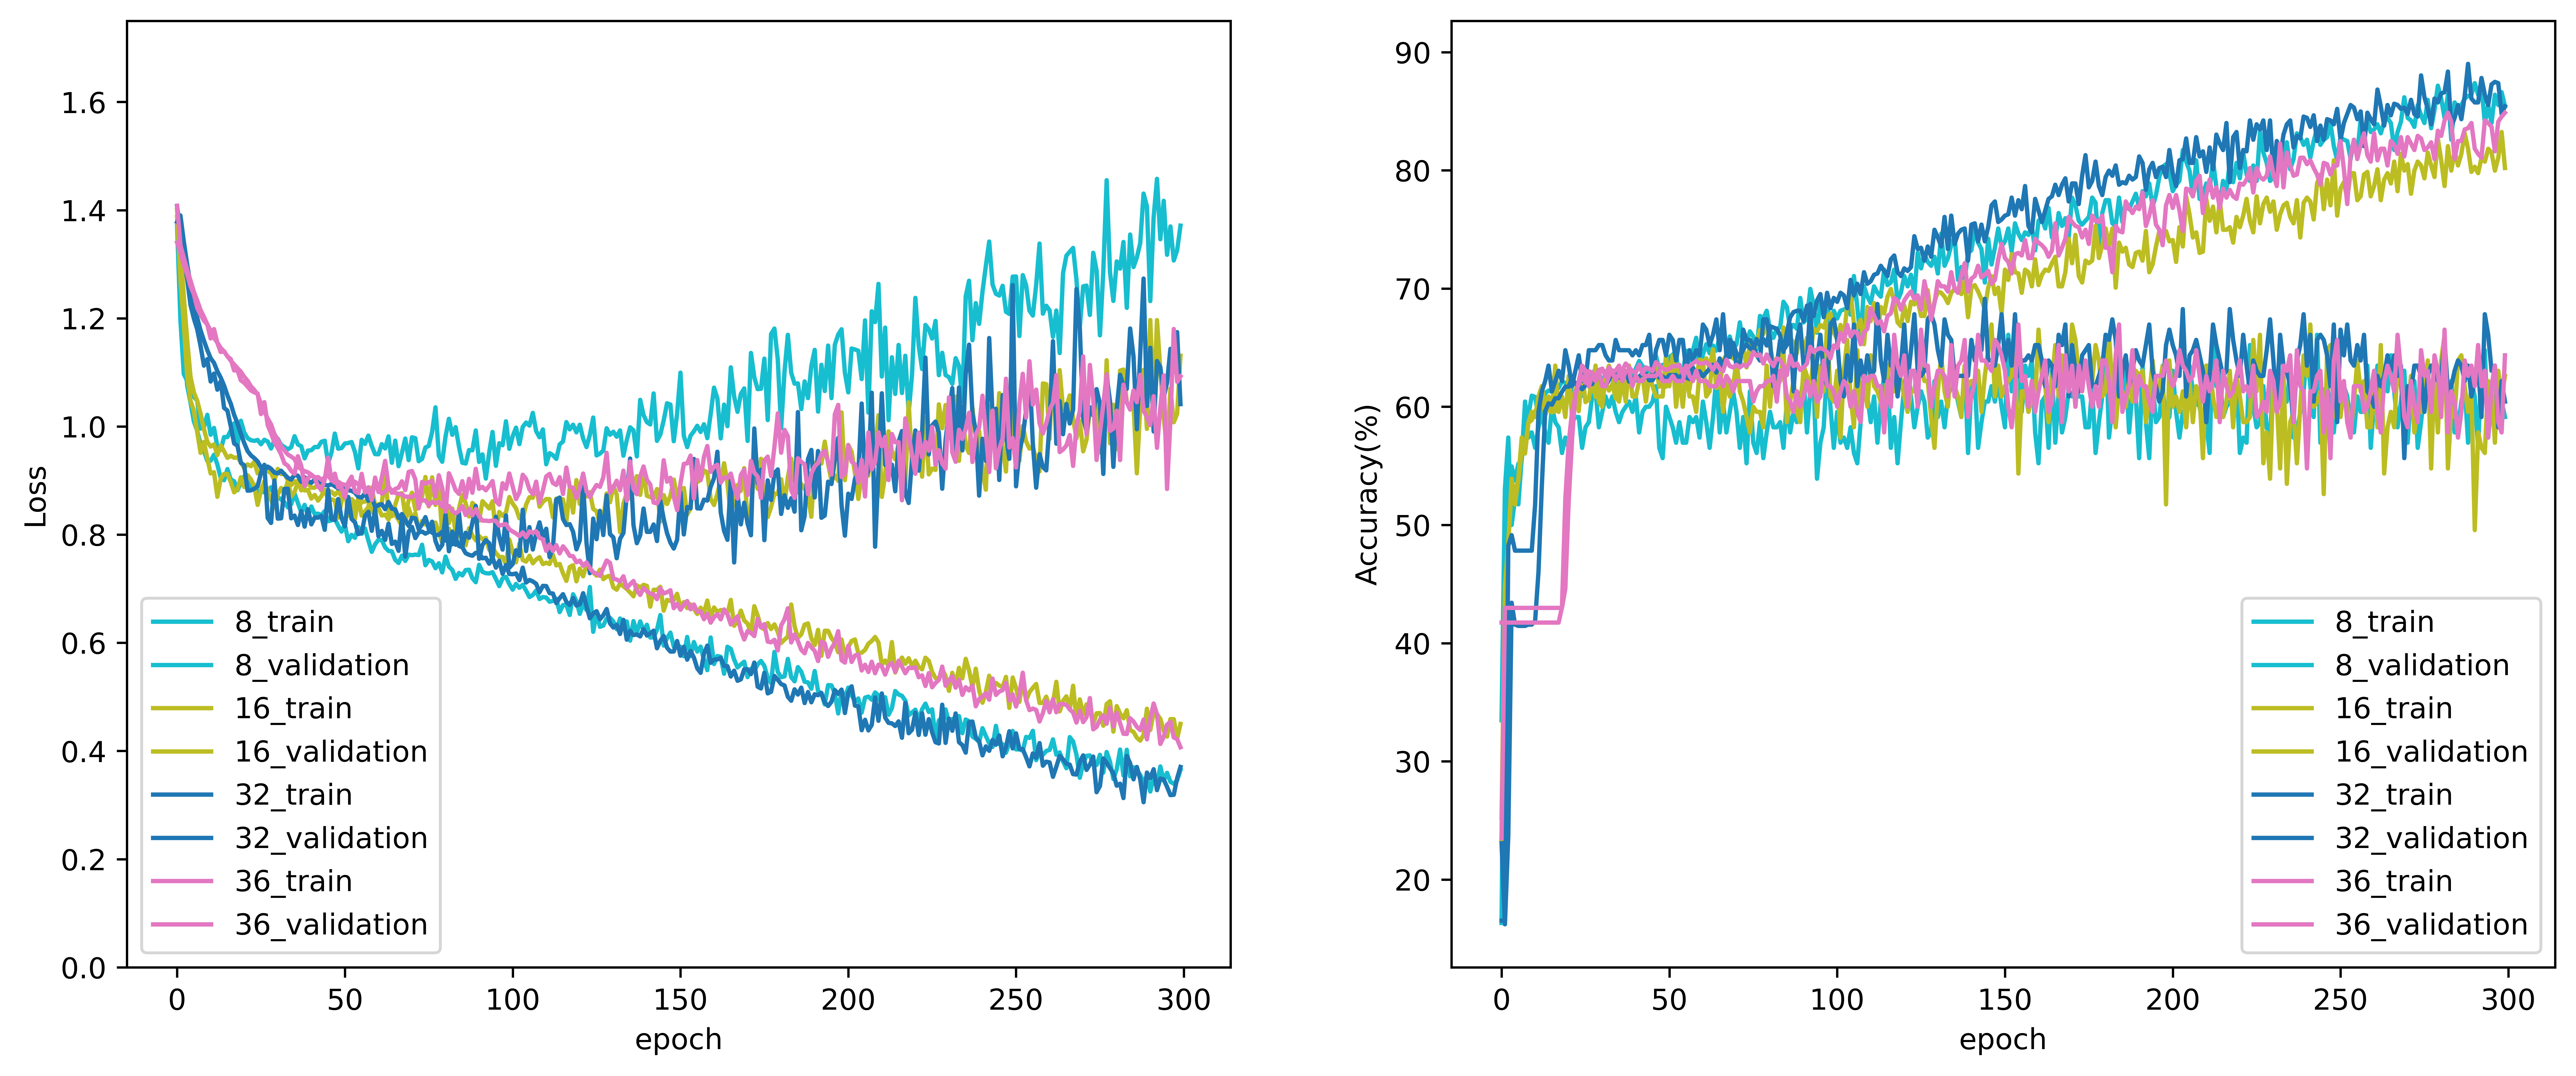

In [47]:
plt.rcParams['figure.dpi'] = 800
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
IRN8=pd.read_csv('IN_7_0316.csv')
IRN16=pd.read_csv('IN_7_0316_16.csv')
IRN32=pd.read_csv('IN_7_0316_32.csv')
IRN36=pd.read_csv('IN_7_0316_36.csv')
x = [i for i in range(300)]
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(x, IRN8.iloc[:,1],'tab:cyan')
plt.plot(x, IRN8.iloc[:,-2],'tab:cyan')
plt.plot(x, IRN16.iloc[:,1],'tab:olive')
plt.plot(x, IRN16.iloc[:,-2],'tab:olive')
plt.plot(x, IRN32.iloc[:,1],'tab:blue')
plt.plot(x, IRN32.iloc[:,-2],'tab:blue')
plt.plot(x, IRN36.iloc[:,1],'tab:pink')
plt.plot(x, IRN36.iloc[:,-2],'tab:pink')
plt.legend(['8_train','8_validation','16_train','16_validation',
           '32_train','32_validation','36_train','36_validation'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.ylim(0,1.75)

plt.subplot(122)
plt.plot(x, IRN8.iloc[:,2],'tab:cyan')
plt.plot(x, IRN8.iloc[:,-1],'tab:cyan')
plt.plot(x, IRN16.iloc[:,2],'tab:olive')
plt.plot(x, IRN16.iloc[:,-1],'tab:olive')
plt.plot(x, IRN32.iloc[:,2],'tab:blue')
plt.plot(x, IRN32.iloc[:,-1],'tab:blue')
plt.plot(x, IRN36.iloc[:,2],'tab:pink')
plt.plot(x, IRN36.iloc[:,-1],'tab:pink')
plt.legend(['8_train','8_validation','16_train','16_validation',
            '32_train','32_validation','36_train','36_validation'])
plt.ylabel('Accuracy(%)')
plt.xlabel('epoch')

# Utilize pseudo labeling

In [6]:
batch_size = 16
transform = transforms.Compose([transforms.Resize((275, 275)),
                                    transforms.RandomRotation((-20,20)),
                                    transforms.RandomCrop((224, 224)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [7]:
test_transform = transforms.Compose([transforms.Resize((275,275)),
                                    transforms.RandomCrop((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


In [8]:
train_dir = r'D:\application for the usa\YU\6. Deep learning\HW 6 NN for cow teats classification\Train'
train_data = ImageFolder(train_dir,transform = transform)


 # Random split
train_set_size = int(len(train_data) * 0.8)
valid_set_size = len(train_data) - train_set_size
train_set, valid_set = random_split(train_data, [train_set_size, valid_set_size])

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_set, batch_size=batch_size, shuffle=True)

In [9]:
test_dataset = TestSet(img_dir = test_dir, transform = transform)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False, num_workers = 0)

In [10]:
model = Incetionresidual().to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6, weight_decay=1e-5)
PATH = 'NN7_0316_155_36.pth'
model.load_state_dict(torch.load(PATH))
model.eval()
additional_img=[]
additional_label=[]
    
CNN_pred=[]
test_y=[]
with torch.no_grad():
    for data in test_loader:
        x, y = data
        #print(len(y))
        x = x.to('cuda')
        outputs = model(x)
        prob = F.softmax(outputs, dim = 1)
        #print(prob)
        topprob, predicted = torch.max(prob, 1)
        CNN_pred+=predicted.tolist()
        test_y+= list(y)
        for i in range(len(topprob)):
            if topprob[i]>=0.8:
                additional_img.append(x[i].to('cpu'))
                additional_label.append(predicted[i].item())
    #print(len(y)) 

C:\Users\User\anaconda3\envs\dlenv\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


12


In [11]:
len(additional_img)

109

In [12]:
type(additional_label)

list

In [13]:
class CustomDataset(Dataset):
    def __init__(self, img_list, label_list, transform=None):
        self.img_list = img_list
        self.label_list = label_list
        self.transform = transform
    
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        img = self.img_list[idx]
        label = self.label_list[idx]
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

In [14]:
ad_x = torch.stack(additional_img) 
ad_y = additional_label
ad_set = CustomDataset(ad_x, ad_y)
ad_loader = DataLoader(dataset=ad_set, batch_size=batch_size,shuffle=True)

In [15]:
cat_set = ConcatDataset([train_set, ad_set])

In [16]:
cat_loader = DataLoader(cat_set, batch_size=batch_size,shuffle=True)

In [17]:
ind=0
for i in cat_loader:
    #print(i)
    ind+=1
    print(i[0].shape,ind)

torch.Size([16, 3, 224, 224]) 1
torch.Size([16, 3, 224, 224]) 2
torch.Size([16, 3, 224, 224]) 3
torch.Size([16, 3, 224, 224]) 4
torch.Size([16, 3, 224, 224]) 5
torch.Size([16, 3, 224, 224]) 6
torch.Size([16, 3, 224, 224]) 7
torch.Size([16, 3, 224, 224]) 8
torch.Size([16, 3, 224, 224]) 9
torch.Size([16, 3, 224, 224]) 10
torch.Size([16, 3, 224, 224]) 11
torch.Size([16, 3, 224, 224]) 12
torch.Size([16, 3, 224, 224]) 13
torch.Size([16, 3, 224, 224]) 14
torch.Size([16, 3, 224, 224]) 15
torch.Size([16, 3, 224, 224]) 16
torch.Size([16, 3, 224, 224]) 17
torch.Size([16, 3, 224, 224]) 18
torch.Size([16, 3, 224, 224]) 19
torch.Size([16, 3, 224, 224]) 20
torch.Size([16, 3, 224, 224]) 21
torch.Size([16, 3, 224, 224]) 22
torch.Size([16, 3, 224, 224]) 23
torch.Size([16, 3, 224, 224]) 24
torch.Size([16, 3, 224, 224]) 25
torch.Size([16, 3, 224, 224]) 26
torch.Size([16, 3, 224, 224]) 27
torch.Size([16, 3, 224, 224]) 28
torch.Size([16, 3, 224, 224]) 29
torch.Size([16, 3, 224, 224]) 30
torch.Size([16, 3, 

In [18]:
import torch
torch.cuda.empty_cache()

In [19]:
from datetime import datetime
start_time = datetime.now()

all_trainloss= []
all_valloss= []
all_acc = []
all_train_acc=[]
steps = 150

for epoch in range(steps):
    train_loss = 0
    train_correct=0
    for batch in cat_loader:
        x, y = batch

        x, y = x.to('cuda'), y.to('cuda')
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)      
        loss.backward()
        optimizer.step() 
        train_loss+=loss.item()   
        predict = pred.argmax(dim=1, keepdim=True)
        train_correct += predict.eq(y.view_as(predict)).sum().item()
        
    train_acc = 100. * train_correct / len(train_loader.dataset)        
        
    
    

    model.eval()
    val_loss = 0
    correct = 0
    for data, target in valid_loader:
        data, target = data.to('cuda'), target.to('cuda')
        output = model(data)
        val_loss += criterion(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
    train_loss/=len(train_loader)
    val_loss /= len(valid_loader)
    accuracy = 100. * correct / len(valid_loader.dataset)
    
    #scheduler.step(val_loss)
    
    if accuracy >= 66 or (epoch+1)%100 == 0:
        PATH = f'NN8_0323_{epoch+1}_16.pth'
        torch.save(model.state_dict(), PATH)        
    
    all_trainloss.append(train_loss)
    all_train_acc.append(train_acc)    
    all_valloss.append(val_loss)
    all_acc.append(accuracy)
    
    if (epoch+1)%10 !=0:
        print(f'Epoch:{epoch+1} | Train Loss: {train_loss}| train_acc:{train_acc} | Validation Loss:{val_loss} | val_acc:{accuracy}')
        print()
        
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Epoch:1 | Train Loss: 0.7437545035419793| train_acc:81.39281828073993 | Validation Loss:0.6823781510194142 | val_acc:73.47826086956522

Epoch:2 | Train Loss: 0.7107023545380297| train_acc:83.67791077257888 | Validation Loss:0.7081596195697785 | val_acc:73.04347826086956

Epoch:3 | Train Loss: 0.7196824309127084| train_acc:84.54842219804135 | Validation Loss:0.7021543085575104 | val_acc:69.56521739130434

Epoch:4 | Train Loss: 0.7327586885156303| train_acc:82.04570184983677 | Validation Loss:0.6822949012120565 | val_acc:72.17391304347827

Epoch:5 | Train Loss: 0.7223668052204724| train_acc:82.15451577801959 | Validation Loss:0.7173022031784058 | val_acc:67.82608695652173

Epoch:6 | Train Loss: 0.6992353586287334| train_acc:84.76605005440696 | Validation Loss:0.6629764417807261 | val_acc:73.91304347826087

Epoch:7 | Train Loss: 0.7324966449162056| train_acc:83.13384113166485 | Validation Loss:0.714510562022527 | val_acc:73.04347826086956

Epoch:8 | Train Loss: 0.7313627287231642| train_a

Epoch:68 | Train Loss: 0.574991497757106| train_acc:88.57453754080522 | Validation Loss:0.8025940597057343 | val_acc:65.21739130434783

Epoch:69 | Train Loss: 0.5588890791966997| train_acc:91.0772578890098 | Validation Loss:0.7784419238567353 | val_acc:67.82608695652173

Epoch:71 | Train Loss: 0.5527572983811642| train_acc:91.51251360174102 | Validation Loss:0.7684044758478801 | val_acc:67.3913043478261

Epoch:72 | Train Loss: 0.6034595645193396| train_acc:89.6626768226333 | Validation Loss:0.6923060327768326 | val_acc:68.26086956521739

Epoch:73 | Train Loss: 0.564065348228504| train_acc:89.55386289445049 | Validation Loss:0.7322742362817128 | val_acc:71.30434782608695

Epoch:74 | Train Loss: 0.536080366835512| train_acc:91.40369967355822 | Validation Loss:0.7504094958305358 | val_acc:64.78260869565217

Epoch:75 | Train Loss: 0.5559219139917143| train_acc:91.29488574537541 | Validation Loss:0.7961403826872507 | val_acc:66.95652173913044

Epoch:76 | Train Loss: 0.5653855492328775| trai

Epoch:135 | Train Loss: 0.44018035638948966| train_acc:94.99455930359086 | Validation Loss:0.9086225668589274 | val_acc:67.82608695652173

Epoch:136 | Train Loss: 0.4102237042168091| train_acc:97.60609357997824 | Validation Loss:0.8546204209327698 | val_acc:68.26086956521739

Epoch:137 | Train Loss: 0.4556197200355859| train_acc:94.66811751904244 | Validation Loss:0.8514522254467011 | val_acc:69.1304347826087

Epoch:138 | Train Loss: 0.47208573669195175| train_acc:93.90642002176278 | Validation Loss:0.9429733912150066 | val_acc:61.73913043478261

Epoch:139 | Train Loss: 0.41718506312062| train_acc:96.84439608269858 | Validation Loss:0.8359243293603261 | val_acc:66.95652173913044

Epoch:141 | Train Loss: 0.4310352977622172| train_acc:96.62676822633297 | Validation Loss:0.9021853864192962 | val_acc:71.30434782608695

Epoch:142 | Train Loss: 0.4683983734455602| train_acc:93.36235038084875 | Validation Loss:0.9828750570615132 | val_acc:66.95652173913044

Epoch:143 | Train Loss: 0.426524996

In [23]:
df = pd.DataFrame(zip(all_trainloss,all_train_acc,all_valloss,all_acc))
df.to_csv('IN_8_0323_16.csv')

In [21]:
index = (df[df.iloc[:,3]>=66].index.values)+1

In [22]:
for i in index:

    PATH = f'NN8_0323_{i}_16.pth'
    model.load_state_dict(torch.load(PATH))
    model.eval()
    
    CNN_pred=[]
    test_y=[]
    with torch.no_grad():
        for data in test_loader:
            x, y = data
            #print(y)
            x = x.to('cuda')
            outputs = model(x)
            _, predicted = torch.max(outputs.data, 1)
            CNN_pred+=predicted.tolist()
            test_y+= list(y)
    res =  pd.DataFrame(list(zip(test_y, CNN_pred)))
    res.to_csv(f'NN8_0323_{i}_16_prediction.csv',index=False,header=False)

Text(0.5, 0, 'epoch')

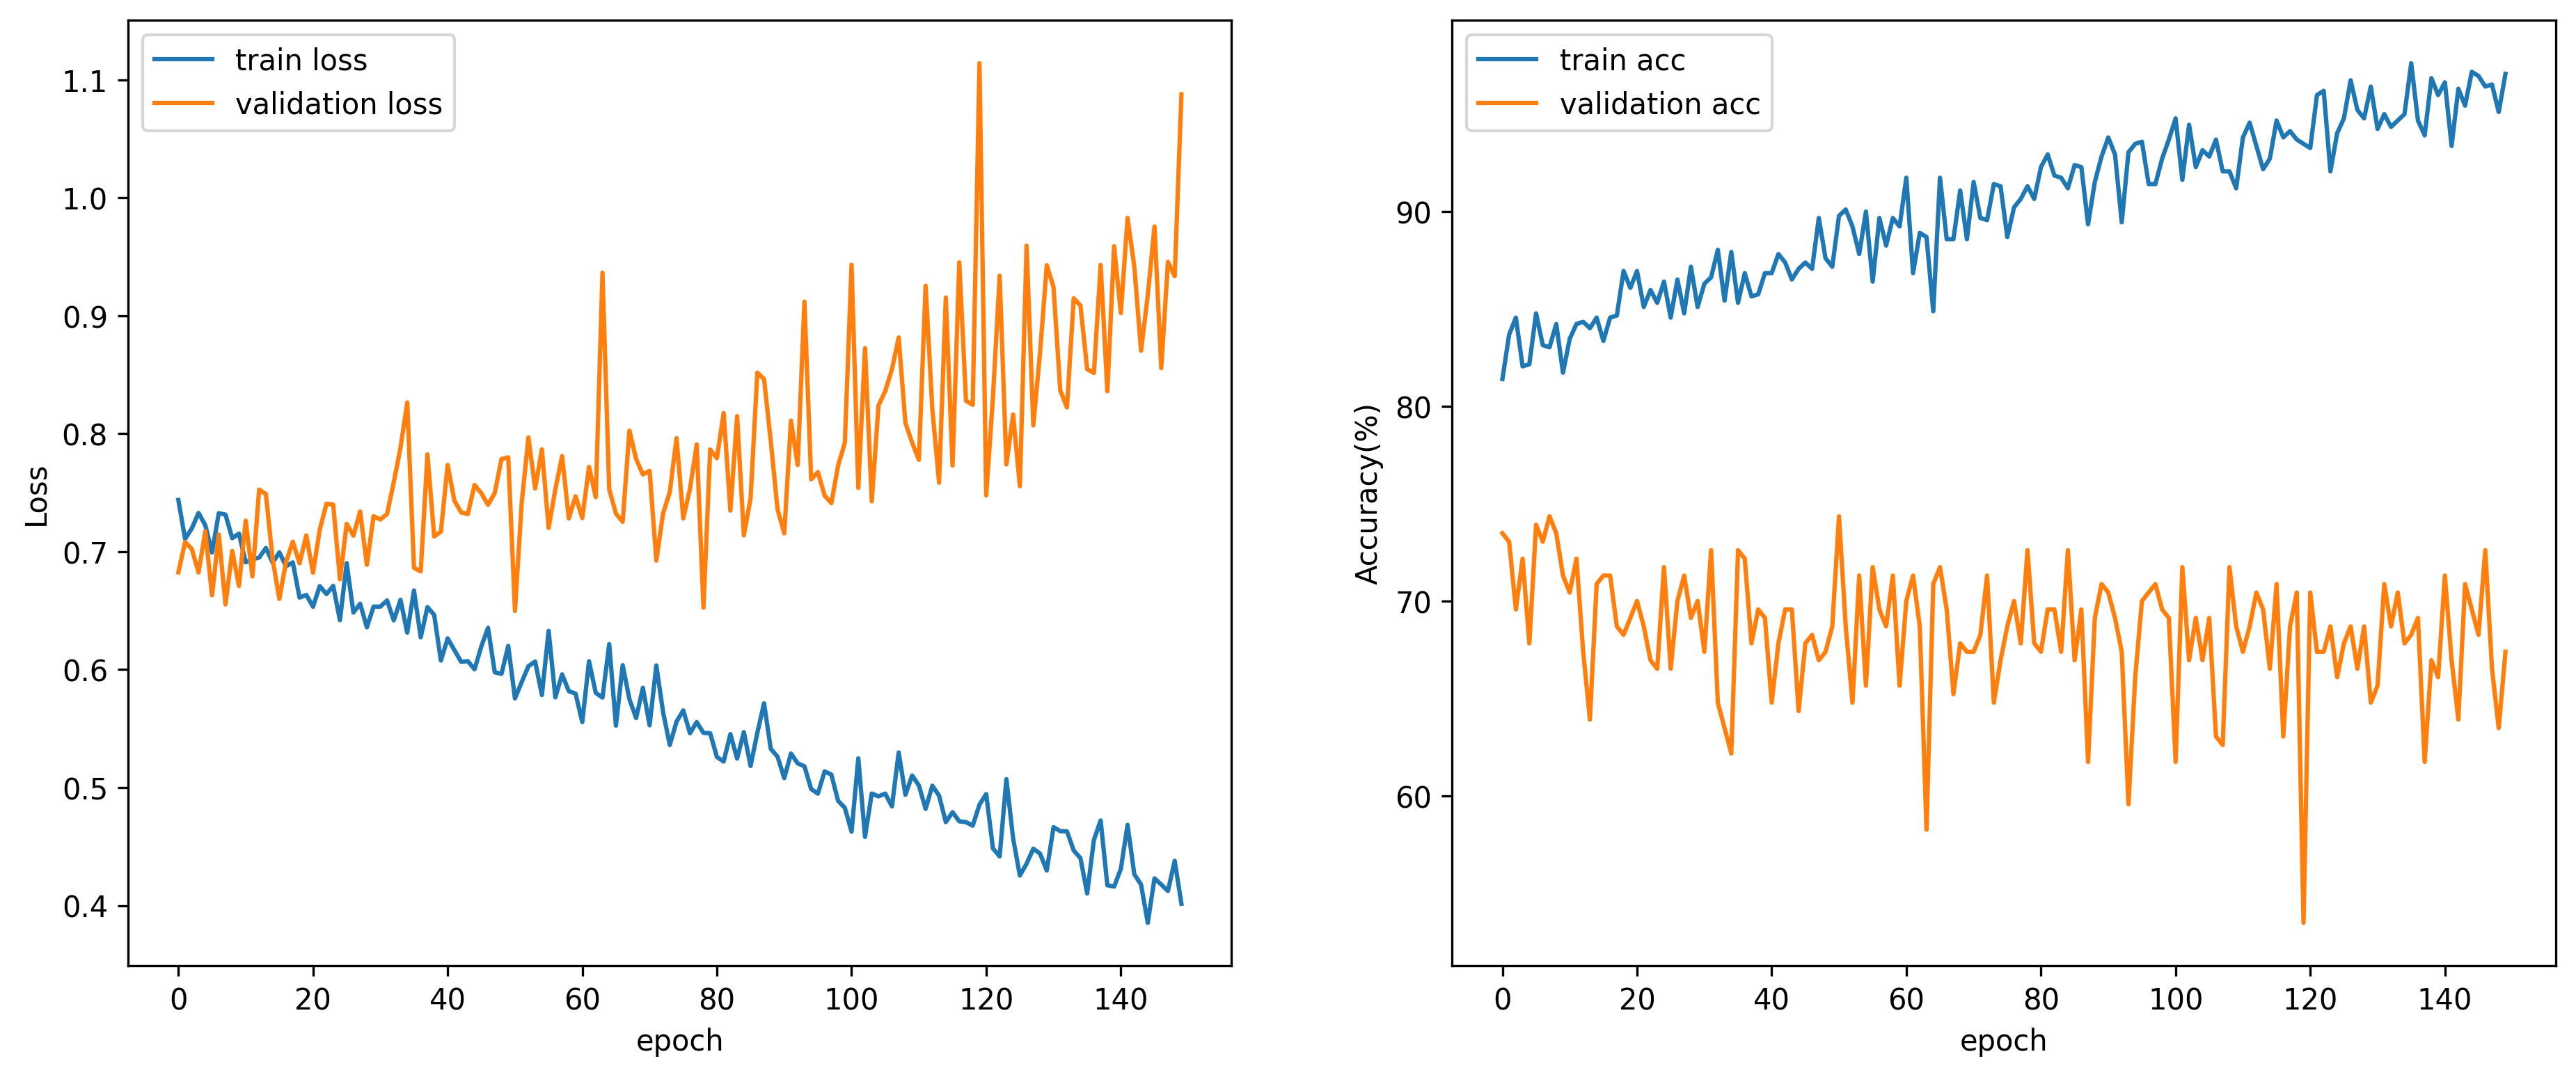

In [26]:
plt.rcParams['figure.dpi'] = 300
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
#CNN=pd.read_csv('NN_7_0316_2.csv')
IRN=pd.read_csv('IN_8_0323_16.csv')
x = [i for i in range(150)]
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(x, IRN.iloc[:,1])
plt.plot(x, IRN.iloc[:,-2])
plt.legend(['train loss','validation loss','train loss','validation loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')


plt.subplot(122)
plt.plot(x, IRN.iloc[:,2])
plt.plot(x, IRN.iloc[:,-1])
plt.legend(['train acc','validation acc','train acc','validation acc'])
plt.ylabel('Accuracy(%)')
plt.xlabel('epoch')

# 3. Evaluate your model using the developed software

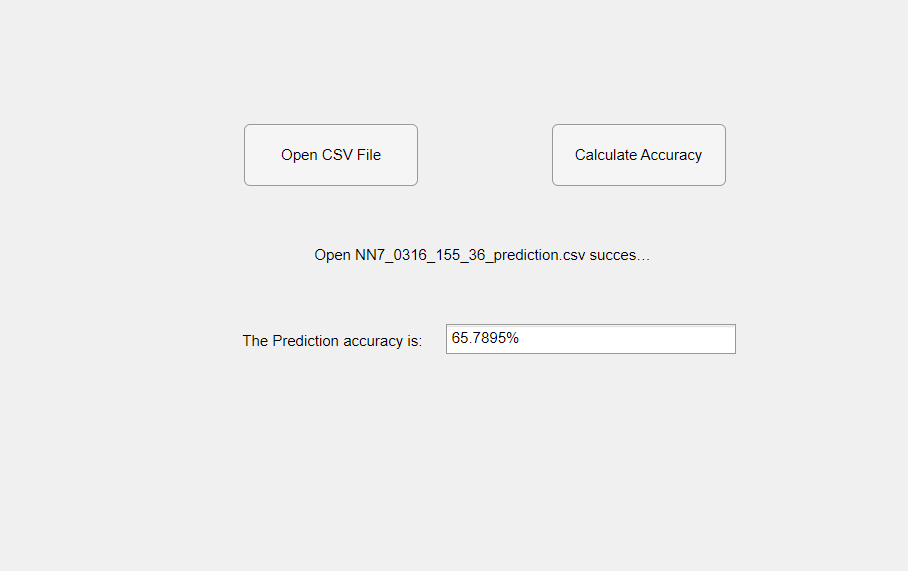

### After using pseudo labeling

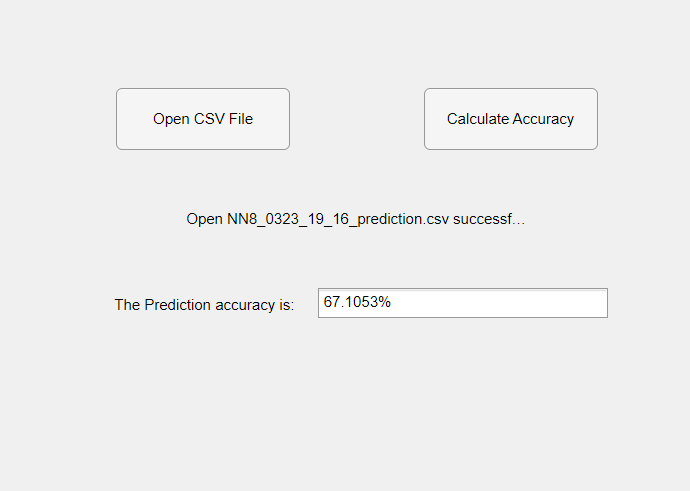

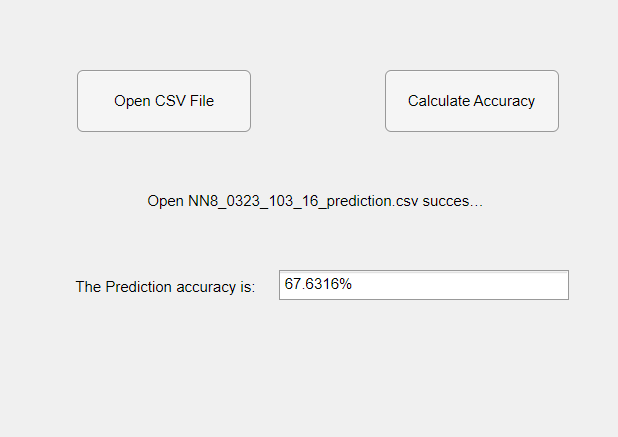

# 4. Compare results with SCTL paper. Requirement: performance is better than VGG16: 66.8%

# 5. Write a four-page paper report using the shared LaTex template. Upload your paper to ResearchGate or Arxiv, and put your paper link here.¶

### https://www.researchgate.net/profile/Sheng-Han-Yueh/publications

# 6. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points

(4). Method  ---- 20 points

(5). Results ---- 20 points

(6). Discussion - 10 points